# Trabalho de IA

> VISÃO COMPUTACIONAL

Projeto 1 - Identificação de relógios de água;

[DataSet](https://www.kaggle.com/datasets/tapakah68/yandextoloka-water-meters-dataset)



In [ ]:
retangulo_ou_poligono = 'retangulo' # @param ["poligono", "retangulo"]

###IMPORTAÇÃO BIBLIOTECA

In [ ]:
import os
from google.colab import files
import matplotlib.pyplot as plt
import cv2
from glob import glob
import pandas as pd
import json
import numpy as np
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau


from google.colab import userdata
import os
import matplotlib.pyplot as plt
import cv2
from glob import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
from sklearn.linear_model import LinearRegression  # Ou outro modelo de regressão
from sklearn.model_selection import train_test_split


###CONFIGURAÇÃO KEGGLE


In [ ]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!if [ ! -f "/content/yandextoloka-water-meters-dataset.zip" ]; then kaggle datasets download  tapakah68/yandextoloka-water-meters-dataset; fi
!if [ ! -d "/content/WaterMeters/" ]; then unzip yandextoloka-water-meters-dataset.zip; fi

###ANALISE DATASET

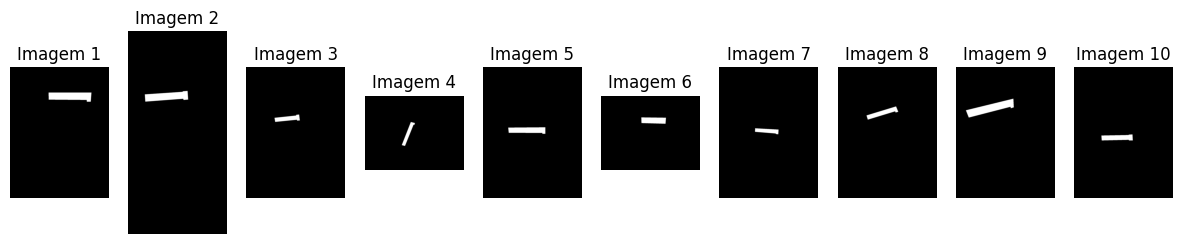

In [ ]:
image_paths = glob("WaterMeters/masks/*.jpg")

def show_images(paths, num_images=5):
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(paths[:num_images]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converter de BGR para RGB
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Imagem {i+1}")
    plt.show()

show_images(image_paths, 10)

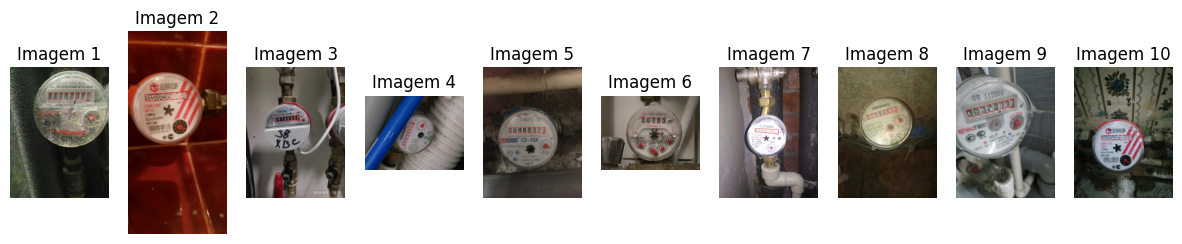

In [ ]:
image_paths = glob("WaterMeters/collage/*.jpg")


def show_images(paths, num_images=10):
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(paths[:num_images]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converter de BGR para RGB
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Imagem {i+1}")
    plt.show()


show_images(image_paths)

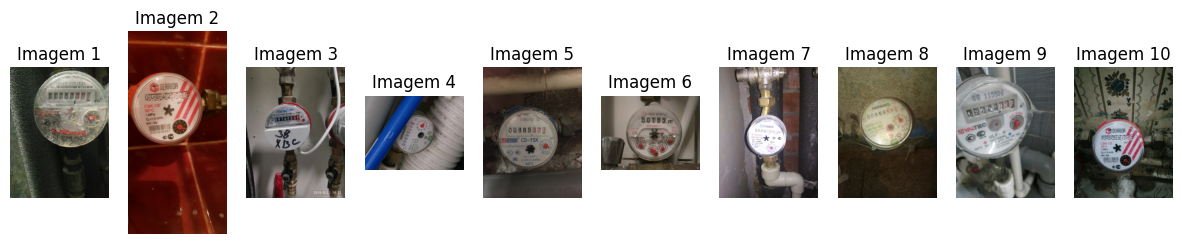

In [ ]:
image_paths = glob("WaterMeters/images/*.jpg")


def show_images(paths, num_images=10):
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(paths[:num_images]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converter de BGR para RGB
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Imagem {i+1}")
    plt.show()


show_images(image_paths)

In [ ]:
!ls WaterMeters/masks

id_1000_value_176_881.jpg    id_254_value_386_38.jpg	id_628_value_199_34.jpg
id_1001_value_1113_124.jpg   id_255_value_172_542.jpg	id_629_value_584_801.jpg
id_1002_value_105_174.jpg    id_256_value_511_562.jpg	id_62_value_367_401.jpg
id_1003_value_209_317.jpg    id_257_value_183_387.jpg	id_630_value_164_0.jpg
id_1004_value_37_176.jpg     id_258_value_619_0.jpg	id_631_value_446_685.jpg
id_1005_value_273_47.jpg     id_259_value_0_078.jpg	id_632_value_1369_0.jpg
id_1006_value_66_009.jpg     id_25_value_328_484.jpg	id_633_value_43_701.jpg
id_1007_value_60_219.jpg     id_260_value_120_115.jpg	id_634_value_218_209.jpg
id_1008_value_95_912.jpg     id_261_value_80_19.jpg	id_635_value_195_465.jpg
id_1009_value_133_679.jpg    id_262_value_409_011.jpg	id_636_value_133_864.jpg
id_100_value_51_256.jpg      id_263_value_87_006.jpg	id_637_value_888_224.jpg
id_1010_value_109_919.jpg    id_264_value_104_406.jpg	id_638_value_0_87.jpg
id_1011_value_567_0.jpg      id_265_value_211_872.jpg	id_639_value_21_

In [ ]:
labels = pd.read_csv('WaterMeters/data.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


print(labels.head())


                 photo_name    value                                           location
0   id_53_value_595_825.jpg  595.825  {'type': 'polygon', 'data': [{'x': 0.30788, 'y...
1   id_553_value_65_475.jpg   65.475  {'type': 'polygon', 'data': [{'x': 0.26133, 'y...
2    id_407_value_21_86.jpg   21.860  {'type': 'polygon', 'data': [{'x': 0.27545, 'y...
3  id_252_value_313_322.jpg  313.322  {'type': 'polygon', 'data': [{'x': 0.21967, 'y...
4  id_851_value_305_162.jpg  305.162  {'type': 'polygon', 'data': [{'x': 0.06983, 'y...


In [ ]:
print(labels.isnull().sum())

photo_name    0
value         0
location      0
dtype: int64


# Pré-Processamento dos Dados

In [ ]:
import json
import math

def ajustar_aspas(texto):
    return texto.replace("'", '"')

def retorna_qd_pontos(pontos):
  return len(pontos)

def extrair_retangulo(location_json):
    """
    Extrai os limites do boundbox (retângulo mínimo) de uma lista de coordenadas.
    """
    pontos = location_json['data']
    x_coords = [p['x'] for p in pontos]
    y_coords = [p['y'] for p in pontos]

    x_min = min(x_coords)
    x_max = max(x_coords)
    y_min = min(y_coords)
    y_max = max(y_coords)


    return {
        'x_min': x_min,
        'y_min': y_min,
        'x_max': x_max,
        'y_max': y_max
    }

def adicionar_ponto_medio(pontos):
    # Função para calcular a distância entre dois pontos
    def distancia(p1, p2):
        return math.sqrt((p1['x'] - p2['x'])**2 + (p1['y'] - p2['y'])**2)

    # Inicializando a menor distância e os índices dos pontos correspondentes
    menor_distancia = float('inf')
    indice_ponto1 = indice_ponto2 = -1

    # Encontrando os dois pontos com a menor distância
    for i in range(len(pontos)):
        for j in range(i + 1, len(pontos)):
            dist = distancia(pontos[i], pontos[j])
            if dist < menor_distancia:
                menor_distancia = dist
                indice_ponto1, indice_ponto2 = i, j

    # Calculando o ponto médio
    ponto_medio = {
        'x': (pontos[indice_ponto1]['x'] + pontos[indice_ponto2]['x']) / 2,
        'y': (pontos[indice_ponto1]['y'] + pontos[indice_ponto2]['y']) / 2
    }

    # Inserindo o ponto médio entre os dois pontos com menor distância
    if indice_ponto1 < indice_ponto2:
        pontos.insert(indice_ponto2, ponto_medio)
    else:
        pontos.insert(indice_ponto1, ponto_medio)

    return pontos
def extrair_poligono(poligono, qtd_pontos=8):
  pontos = poligono["data"]
  if len(pontos) == qtd_pontos:
    return pontos
  pontos_atualizados = adicionar_ponto_medio(pontos)
  while len(pontos_atualizados) < qtd_pontos:
    pontos_atualizados = adicionar_ponto_medio(pontos_atualizados)
  return pontos_atualizados

image_paths = glob("WaterMeters/images/*.jpg")
def find_path(name):
  for image_path in image_paths:
    if name in image_path:
      return image_path
  return None



In [ ]:
labels = pd.read_csv('WaterMeters/data.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
labels['location_dict'] = labels['location'].apply(ajustar_aspas).apply(json.loads)
labels['path'] = labels['photo_name'].apply(find_path)
if retangulo_ou_poligono == 'retangulo':
  labels['bounding_box'] = labels['location_dict'].apply(extrair_retangulo)
else:
  labels['bounding_box'] = labels['location_dict'].apply(extrair_poligono)

labels['qtd_pontos'] = labels['location_dict'].apply(retorna_qd_pontos)
labels

,photo_name,value,location,location_dict,path,bounding_box,qtd_pontos
0,id_53_value_595_825.jpg,595.825,"{'type': 'polygon', 'data': [{'x': 0.30788, 'y...","{'type': 'polygon', 'data': [{'x': 0.30788, 'y...",WaterMeters/images/id_53_value_595_825.jpg,"{'x_min': 0.09172124, 'y_min': 0.0668118079519...",2
1,id_553_value_65_475.jpg,65.475,"{'type': 'polygon', 'data': [{'x': 0.26133, 'y...","{'type': 'polygon', 'data': [{'x': 0.26133, 'y...",WaterMeters/images/id_553_value_65_475.jpg,"{'x_min': 0.05861790697674419, 'y_min': 0.0701...",2
2,id_407_value_21_86.jpg,21.860,"{'type': 'polygon', 'data': [{'x': 0.27545, 'y...","{'type': 'polygon', 'data': [{'x': 0.27545, 'y...",WaterMeters/images/id_407_value_21_86.jpg,"{'x_min': 0.06178510877719429, 'y_min': 0.0546...",2
3,id_252_value_313_322.jpg,313.322,"{'type': 'polygon', 'data': [{'x': 0.21967, 'y...","{'type': 'polygon', 'data': [{'x': 0.21967, 'y...",WaterMeters/images/id_252_value_313_322.jpg,"{'x_min': 0.06488000999999999, 'y_min': 0.1140...",2
4,id_851_value_305_162.jpg,305.162,"{'type': 'polygon', 'data': [{'x': 0.06983, 'y...","{'type': 'polygon', 'data': [{'x': 0.06983, 'y...",WaterMeters/images/id_851_value_305_162.jpg,"{'x_min': 0.02087917, 'y_min': 0.0933270292573...",2
...,...,...,...,...,...,...,...
1239,id_255_value_172_542.jpg,172.542,"{'type': 'polygon', 'data': [{'x': 0.2368, 'y'...","{'type': 'polygon', 'data': [{'x': 0.2368, 'y'...",WaterMeters/images/id_255_value_172_542.jpg,"{'x_min': 0.0708032, 'y_min': 0.10664632408102...",2
1240,id_878_value_97_299.jpg,97.299,"{'type': 'polygon', 'data': [{'x': 0.30909, 'y...","{'type': 'polygon', 'data': [{'x': 0.30909, 'y...",WaterMeters/images/id_878_value_97_299.jpg,"{'x_min': 0.09241790999999999, 'y_min': 0.1225...",2
1241,id_649_value_146_443.jpg,146.443,"{'type': 'polygon', 'data': [{'x': 0.20591, 'y...","{'type': 'polygon', 'data': [{'x': 0.20591, 'y...",WaterMeters/images/id_649_value_146_443.jpg,"{'x_min': 0.05801795999999999, 'y_min': 0.0848...",2
1242,id_396_value_228_944.jpg,228.944,"{'type': 'polygon', 'data': [{'x': 0.35106, 'y...","{'type': 'polygon', 'data': [{'x': 0.35106, 'y...",WaterMeters/images/id_396_value_228_944.jpg,"{'x_min': 0.0787448912228057, 'y_min': 0.17747...",2


In [ ]:
labels.to_csv('WaterMeters/data_with_bounding_boxes.csv', index=False)

In [ ]:
labels['bounding_box'][0]

{'x_min': 0.09172124,
 'y_min': 0.066811807951988,
 'x_max': 0.16952403,
 'y_max': 0.07568311327831957}

In [ ]:
if retangulo_ou_poligono == 'retangulo':
  bounding_boxes = np.array([[bb['x_min'], bb['y_min'], bb['x_max'], bb['y_max']] for bb in labels['bounding_box']])
else:
  bounding_boxes = np.array([np.concatenate([[b['x'], b['y']]for b in bb ]) for bb in labels['bounding_box']])
bounding_boxes

array([[0.09172124, 0.06681181, 0.16952403, 0.07568311],
       [0.05861791, 0.07018427, 0.07623042, 0.18373251],
       [0.06178511, 0.05466318, 0.08733357, 0.22907287],
       ...,
       [0.05801796, 0.08488863, 0.21339331, 0.1055562 ],
       [0.07874489, 0.17747444, 0.13422027, 0.2016157 ],
       [0.11033399, 0.07786612, 0.24514711, 0.0878384 ]])

# Pré-processamento das imagens para usar no modelo

In [ ]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (299, 299))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

In [ ]:
X = np.array([preprocess_image(img_path) for img_path in labels['path']])
X = np.concatenate(X, axis=0)

In [ ]:
X

In [ ]:
y = bounding_boxes
display(y)

array([[0.09172124, 0.06681181, 0.16952403, 0.07568311],
       [0.05861791, 0.07018427, 0.07623042, 0.18373251],
       [0.06178511, 0.05466318, 0.08733357, 0.22907287],
       ...,
       [0.05801796, 0.08488863, 0.21339331, 0.1055562 ],
       [0.07874489, 0.17747444, 0.13422027, 0.2016157 ],
       [0.11033399, 0.07786612, 0.24514711, 0.0878384 ]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
base_model = InceptionV3(weights='imagenet',
                         include_top=False,
                         input_shape=(299, 299, 3)
                         )

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-100:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)

x = Dense(16, activation='relu')(x)

if retangulo_ou_poligono == 'retangulo':
  predictions = Dense(4, activation='linear')(x)
else:
  predictions = Dense(16, activation='linear')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# Contar camadas treináveis
trainable_layers = sum([1 for layer in model.layers if layer.trainable])

# Contar camadas não treináveis
non_trainable_layers = sum([1 for layer in model.layers if not layer.trainable])

print("Camadas treináveis:", trainable_layers)
print("Camadas não treináveis:", non_trainable_layers)

Camadas treináveis: 110
Camadas não treináveis: 211


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 23,027,028 (87.84 MB)

 Trainable params: 14,848,308 (56.64 MB)

 Non-trainable params: 8,178,720 (31.20 MB)

In [ ]:
# Treinamento do modelo
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10)
history =  model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - loss: 0.0251 - mae: 0.1103 - val_loss: 0.8230 - val_mae: 0.6244 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 205ms/step - loss: 0.0025 - mae: 0.0386 - val_loss: 0.0184 - val_mae: 0.0972 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - loss: 0.0018 - mae: 0.0332 - val_loss: 0.0015 - val_mae: 0.0299 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - loss: 0.0014 - mae: 0.0288 - val_loss: 0.0019 - val_mae: 0.0342 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - loss: 0.0014 - mae: 0.0280 - val_loss: 0.0012 - val_mae: 0.0263 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - loss: 0.0012 - mae: 0.0262 - val_loss: 0.0017 - val_mae: 0.0322 - learning_rate: 0.0010
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 235ms/step - loss: 0.0010 - mae: 0.0243 - val_loss: 0.0016 - val_mae: 0.0310 - learning_rate: 0.0010
E

In [ ]:
# Avaliar o modelo nos dados de teste
loss, mae = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, MAE: {mae}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 3.3885e-04 - mae: 0.0136
Loss: 0.00038698213757015765, MAE: 0.014187236316502094


ANALISANDO O DESEMPENHO DO MODELO

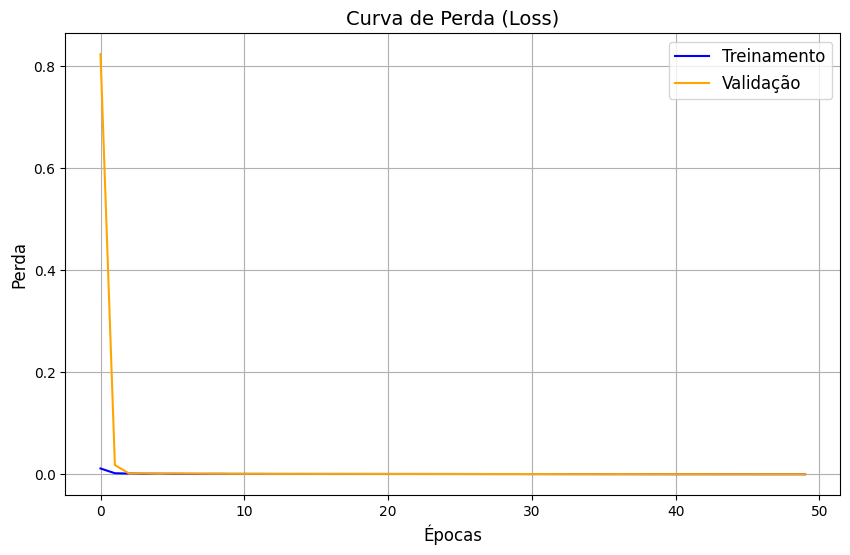

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Treinamento', color='blue')
    plt.plot(history.history['val_loss'], label='Validação', color='orange')
    plt.title('Curva de Perda (Loss)', fontsize=14)
    plt.xlabel('Épocas', fontsize=12)
    plt.ylabel('Perda', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_loss(history)

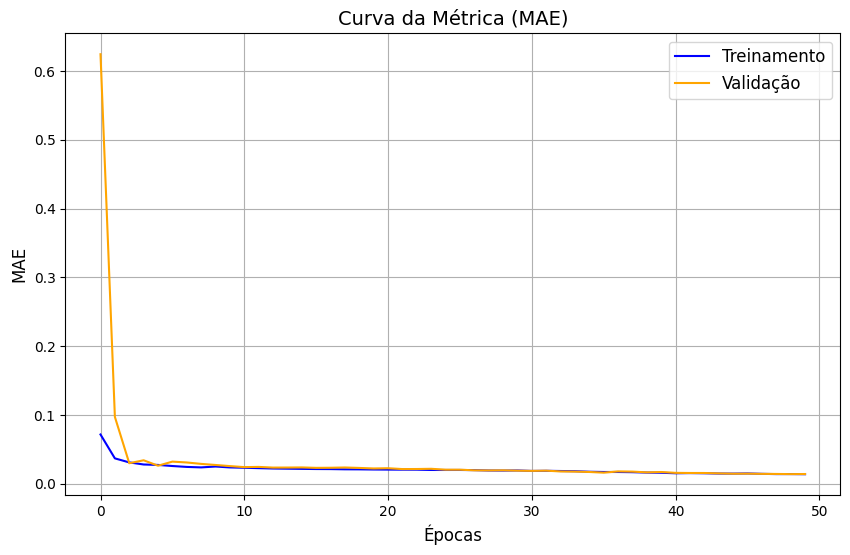

In [ ]:
def plot_metric(history, metric_name='mae'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric_name], label='Treinamento', color='blue')
    plt.plot(history.history[f'val_{metric_name}'], label='Validação', color='orange')
    plt.title(f'Curva da Métrica ({metric_name.upper()})', fontsize=14)
    plt.xlabel('Épocas', fontsize=12)
    plt.ylabel(metric_name.upper(), fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_metric(history, metric_name='mae')

#predição

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Imagem WaterMeters/images/id_1156_value_61_991.jpg
Bounding box prevista para a imagem: [[0.08281497 0.10707942 0.19254166 0.13907273]]
Bouding box real: 1144    {'x_min': 0.03846336, 'y_min': 0.1338299774943...
Name: bounding_box, dtype: object


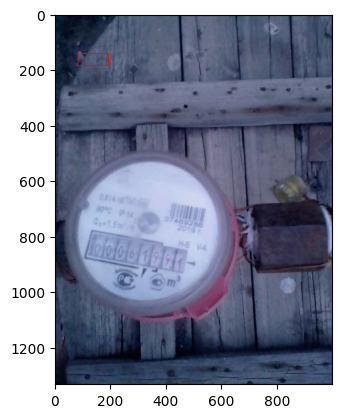

In [ ]:
# Carregar uma imagem de exemplo para previsão (substitua pelo caminho da sua imagem)
import random
numero = random.randint(0, 1243)

image_path_to_predict = image_paths[numero]  # Substitua pelo caminho da imagem desejada
bounding_box_real = str(labels.loc[labels['path'] == image_paths[numero], 'bounding_box'])

# Pré-processar a imagem
img_to_predict = preprocess_image(image_path_to_predict)

# Fazer a previsão
predicted_bounding_box = model.predict(img_to_predict)

# Imprimir a bounding box prevista
print(f"Imagem {image_path_to_predict}")
print(f"Bounding box prevista para a imagem: {predicted_bounding_box}")
print(f"Bouding box real: {bounding_box_real}")

# Para visualizar a bounding box na imagem:
img = cv2.imread(image_path_to_predict)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

if retangulo_ou_poligono == 'retangulo':
  x_min, y_min, x_max, y_max = predicted_bounding_box[0]
  x_min = int(x_min * img.shape[1])
  y_min = int(y_min * img.shape[0])
  x_max = int(x_max * img.shape[1])
  y_max = int(y_max * img.shape[0])

  cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # Desenhar a bounding box
else:
  x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x7, y7, x8, y8 = predicted_bounding_box[0]

  x1 = int(x1 * img.shape[1])
  x2 = int(x2 * img.shape[1])
  x3 = int(x3 * img.shape[1])
  x4 = int(x4 * img.shape[1])
  x5 = int(x5 * img.shape[1])
  x6 = int(x6 * img.shape[1])
  x7 = int(x7 * img.shape[1])
  x8 = int(x8 * img.shape[1])

  y1 = int(y1 * img.shape[0])
  y2 = int(y2 * img.shape[0])
  y3 = int(y3 * img.shape[0])
  y4 = int(y4 * img.shape[0])
  y5 = int(y5 * img.shape[0])
  y6 = int(y6 * img.shape[0])
  y7 = int(y7 * img.shape[0])
  y8 = int(y8 * img.shape[0])

  pts = np.array([[x1, y1], [x2, y2],[x3, y3],[x4, y4],[x5, y5],[x6, y6],[x7, y7],[x8, y8]], np.int32)
  print(pts)
  cv2.polylines(img, [pts], True, (255, 0, 0), 2)  # Desenhar a bounding box
plt.imshow(img)
plt.show()

In [ ]:
# Realizando previsões no conjunto de teste
y_pred = model.predict(X_test)

# Comparando as previsões com os valores reais para algumas imagens
num_images_to_compare = 5

for i in range(num_images_to_compare):
    print(f"\nImagem {i+1}:")
    print("Valores reais (bounding box):", y_test[i])
    print("Valores previstos (bounding box):", y_pred[i])

In [ ]:
import random

num_images_to_predict = 10
random_indices = random.sample(range(len(X_test)), num_images_to_predict)

predictions_df = pd.DataFrame(columns=['Imagem', 'Previsto_x_min', 'Previsto_y_min', 'Previsto_x_max', 'Previsto_y_max', 'Real_x_min', 'Real_y_min', 'Real_x_max', 'Real_y_max'])

for i, index in enumerate(random_indices):
    image_path = image_paths[index]
    image_name = os.path.basename(image_path)

    y_pred_single = model.predict(np.expand_dims(X_test[index], axis=0))

    predictions_df.loc[i] = [
        image_name,
        y_pred_single[0][0], y_pred_single[0][1], y_pred_single[0][2], y_pred_single[0][3],
        y_test[index][0], y_test[index][1], y_test[index][2], y_test[index][3]
    ]

predictions_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


,Imagem,Previsto_x_min,Previsto_y_min,Previsto_x_max,Previsto_y_max,Real_x_min,Real_y_min,Real_x_max,Real_y_max
0,id_277_value_147_577.jpg,0.090384,0.082533,0.210814,0.094898,0.115868,0.084837,0.206750,0.115977
1,id_559_value_281_821.jpg,0.074694,0.080276,0.197844,0.100017,0.074786,0.083327,0.192329,0.094556
2,id_103_value_334_42.jpg,0.083463,0.090495,0.205455,0.113094,0.086306,0.095110,0.200524,0.109168
3,id_938_value_136_897.jpg,0.081645,0.132833,0.146999,0.192691,0.048651,0.151539,0.103638,0.214470
4,id_167_value_2_299.jpg,0.067021,0.080668,0.183391,0.101220,0.088582,0.090514,0.200548,0.111193
5,id_633_value_43_701.jpg,0.092972,0.118265,0.204156,0.154167,0.091578,0.127552,0.194266,0.151043
6,id_203_value_154_089.jpg,0.092420,0.113331,0.205907,0.146963,0.079896,0.123261,0.163412,0.138608
7,id_818_value_525_562.jpg,0.089345,0.091049,0.207472,0.108115,0.146047,0.076331,0.195707,0.082794
8,id_358_value_358_003.jpg,0.082126,0.096306,0.203992,0.125255,0.100087,0.107295,0.190281,0.131944
9,id_694_value_353_497.jpg,0.085418,0.091095,0.218617,0.121125,0.097492,0.100749,0.224675,0.116487


In [ ]:

predictions_df = pd.DataFrame(columns=['Imagem', 'x_min_pred', 'y_min_pred', 'x_max_pred', 'y_max_pred',
                                       'x_min_real', 'y_min_real', 'x_max_real', 'y_max_real'])

num_images_to_predict = 10
random_indices = random.sample(range(len(X_test)), num_images_to_predict)


for i, index in enumerate(random_indices):
    image_path = image_paths[index]
    image_name = os.path.basename(image_path)
    y_pred_single = model.predict(np.expand_dims(X_test[index], axis=0))

    predictions_df.loc[i] = [
        image_name,
        y_pred_single[0][0], y_pred_single[0][1], y_pred_single[0][2], y_pred_single[0][3],
        y_test[index][0], y_test[index][1], y_test[index][2], y_test[index][3]
    ]

# Exibindo a tabela de previsões
predictions_df